In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np

In [2]:
with open("spark-warehouse/numpy/e2/runs/FINAL/runs.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    run_number_list = []
    run_timetaken_list = []
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            run_number_list.append(int(row[0]))
            run_timetaken_list.append(float(row[1]))
            line_count += 1
    print(f'Processed {line_count} lines.')
                  
                  
measures = np.array(run_timetaken_list)

Column names are run, runtime
Processed 2001 lines.


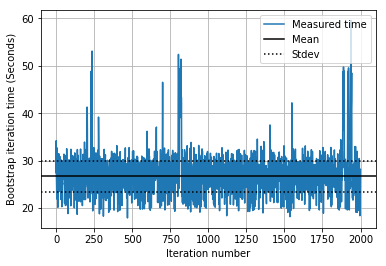

In [3]:
plt.clf()
plt.grid()
plt.ylabel("Bootstrap iteration time (Seconds)")
plt.xlabel("Iteration number")
#plt.title("Bootstrap analysis time measurements \n \
#Measures > 40 seconds omitted from mean and standard deviation\n \
#Total time taken: 15:06:45")

plt.plot(run_number_list, run_timetaken_list)

mean = measures[measures<40].mean()
std = measures[measures<40].std()

plt.axhline(y=mean, color='black', linestyle='-')
plt.axhline(y=mean-std,  color='black', linestyle=':')
plt.axhline(y=mean+std,  color='black', linestyle=':')

plt.legend(["Measured time","Mean", "Stdev"])
plt.savefig("plots/bootstrap_runtime_measures.pdf")

In [9]:

print(measures.mean())
print(measures[measures<40].mean())

27.20189
26.736724756535107


In [10]:
print(measures.std())
print(measures[measures<40].std())

4.395700959790145
3.252297423295052


In [11]:
measures[measures>40].shape

(49,)

In [12]:
measures[measures<22].shape

(182,)

In [13]:
measures[measures<40].sum()

52163.34999999999

# Bootstrap convergence

In [14]:
metrics_basedir = "spark-warehouse/numpy/e2/runs/FINAL/"
#metrics_basedir = "spark-warehouse/numpy/e2/runs/run1/"
n_bootstrap_samples = 2000

In [15]:
def load_model_params(npy_file):
    a = npy_file.item().get("model_coefficients")
    b = npy_file.item().get("model_intercept")
    return a, b

def load_bootstrap_model_params(experiment_path, n_samples):
    work_size = range(0, n_samples)
    coef_mat = None
    intercept_mat = None
    for i in work_size:
        npy_file = np.load(metrics_basedir+str(i)+".npy")
        coef, intercept = load_model_params(npy_file)
        if coef_mat is None:
            coef_mat = coef
        else:
            coef_mat = np.concatenate((coef_mat, coef), axis=0)
        if intercept_mat is None:
            intercept_mat=intercept
        else:
            intercept_mat = np.vstack((intercept_mat, intercept))
    return (coef_mat, intercept_mat)

In [111]:
p_n = [metrics_basedir, n_bootstrap_samples]

coefs_orig, intercepts = load_bootstrap_model_params(p_n[0], p_n[1])

9.31584950204333
(2000, 949)
1415 13.14766980043257


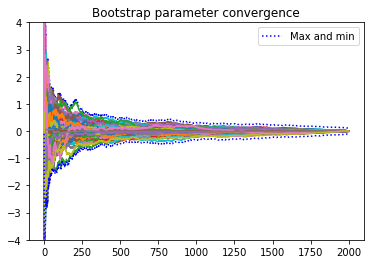

In [134]:
means = np.empty(949)
stds = np.empty(949)
allvar = coefs_orig.var(axis=0)
#print(allvar.shape)
#selection = allvar<0.1
#print(selection.shape)
coefs = coefs_orig.copy()#[:,selection]
end_mean = coefs.mean(axis=0)
print(end_mean.max())
for i in range(1,n_bootstrap_samples):
    mean = (coefs[0:i].mean(axis=0)-end_mean)
   # if np.any(means[means>100]):
    #    print(means[means>100])
        
#    std = coefs[0:i].var(axis=0)
    means =np.vstack([means, mean])
    
#    stds = np.append(stds, std)
#print(means.shape)
#print(np.max(means))
print(means.shape)
print(
    np.argmax(means),
    np.max(means)
)


plt.plot(np.max(means, axis=1)+0.1, linestyle=":", color="blue")
plt.plot(means)

plt.plot(np.min(means, axis=1)-0.1, linestyle = ":", color="blue")
#plt.plot(means+stds, linestyle=":", color="black")
#plt.plot(means-stds, linestyle=":", color="black")
plt.ylim(-4, 4)
plt.title("Bootstrap parameter convergence")
plt.legend(["Max and min"])
plt.savefig("plots/bootstrap_mean_convergence.pdf")
plt.show()